In [1]:
import matplotlib.pyplot as plt
from readers import read_dfs

import numpy as np

# artist tag pairs, user artist pairs

atp, uap, uf = read_dfs()

In [2]:
atp.head()

,userID,artistID,tagID,day,month,year,tagValue,id,name,url,pictureURL
0,2,52,13,1,4,2009,chillout,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
1,43,52,13,1,5,2010,chillout,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
2,255,52,13,1,11,2008,chillout,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
3,283,52,13,1,10,2008,chillout,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
4,357,52,13,1,10,2009,chillout,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...


In [3]:
uap.head()

,userID,artistID,weight,id,name,url,pictureURL
0,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
1,4,51,228,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
2,27,51,85,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
3,28,51,10,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
4,62,51,528,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg


## Question 1

### What are the most popular tags?

 - 75% de los tags solo tienen asignado como maximo 4 artistas.
 - Mantengamos solo los top 200 tags para nuestro analisis. Podemos observar que el tag mas parecido.
 

<AxesSubplot: xlabel='tagValue'>

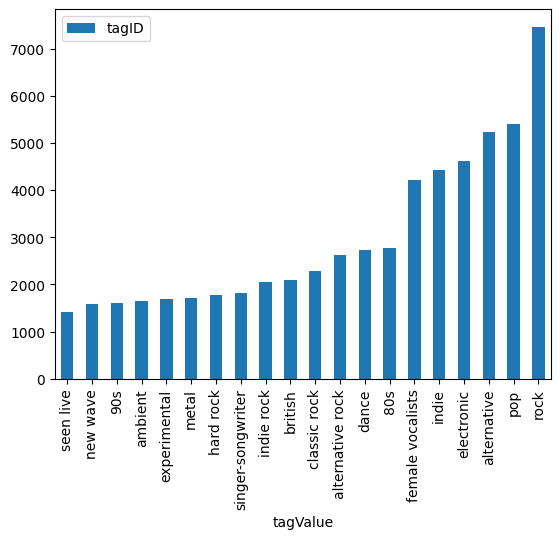

In [4]:
tags_counts = ( atp.groupby("tagID")
                    .count()[["artistID"]]
                    .sort_values("artistID"))

admissable_tag_ids = tags_counts.iloc[-200:,:].index

atp = atp[atp["tagID"].isin(admissable_tag_ids)]

atp.groupby("tagValue").count()[["tagID"]].sort_values("tagID").iloc[-20:,:].plot(kind="bar")


## Question 2
### What are the most popular artists?


In [5]:
popular_artists = uap.groupby("name").sum()["weight"].sort_values(ascending=True)/1000

popular_artists.describe()

/tmp/ipykernel_906450/1335402018.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  popular_artists = uap.groupby("name").sum()["weight"].sort_values(ascending=True)/1000


count    17632.000000
mean         3.923774
std         34.099342
min          0.001000
25%          0.113000
50%          0.350000
75%          1.234250
max       2393.140000
Name: weight, dtype: float64

In [6]:
# Top 20 artists (in 2011)
popular_artists.tail(20)

name
Pink Floyd             466.104
Muse                   485.076
30 Seconds to Mars     485.532
Miley Cyrus            489.065
U2                     493.024
BeyoncÃ©               499.318
Glee Cast              506.453
Evanescence            513.476
Taylor Swift           525.292
Avril Lavigne          525.844
Katy Perry             532.545
The Beatles            662.116
Shakira                688.529
Rihanna                905.423
Madonna                921.198
Paramore               963.449
Christina Aguilera    1058.405
Lady Gaga             1291.387
Depeche Mode          1301.308
Britney Spears        2393.140
Name: weight, dtype: float64

## Question 3
### What vector representation can be used for each artist?

<AxesSubplot: >

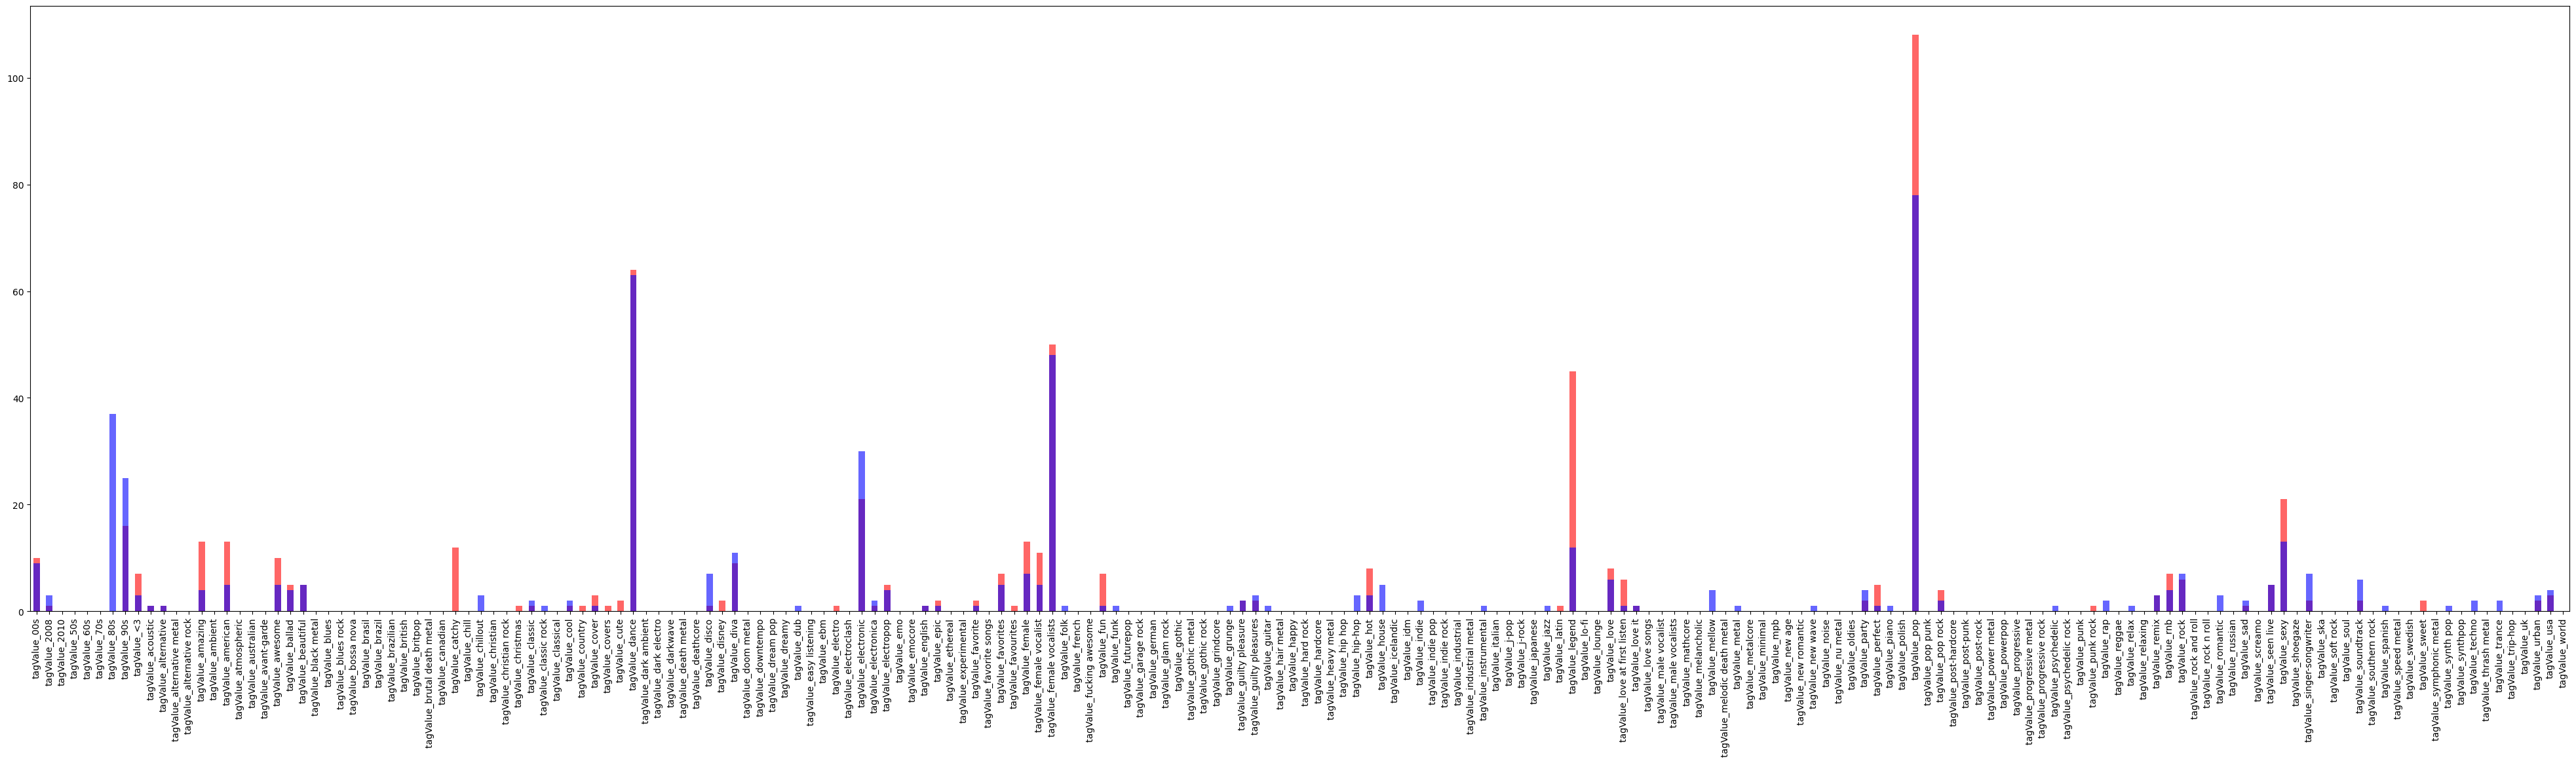

In [7]:
import pandas as pd


artist_vectors = pd.get_dummies(atp[["tagValue","name"]], columns=["tagValue"]).groupby("name").sum()

plt.figure(figsize=(50,12))

artist_vectors.loc["Britney Spears"].plot(kind="bar",color="red", alpha=0.6)
artist_vectors.loc["Madonna"].plot(kind="bar",color="blue", alpha=0.6)

<AxesSubplot: >

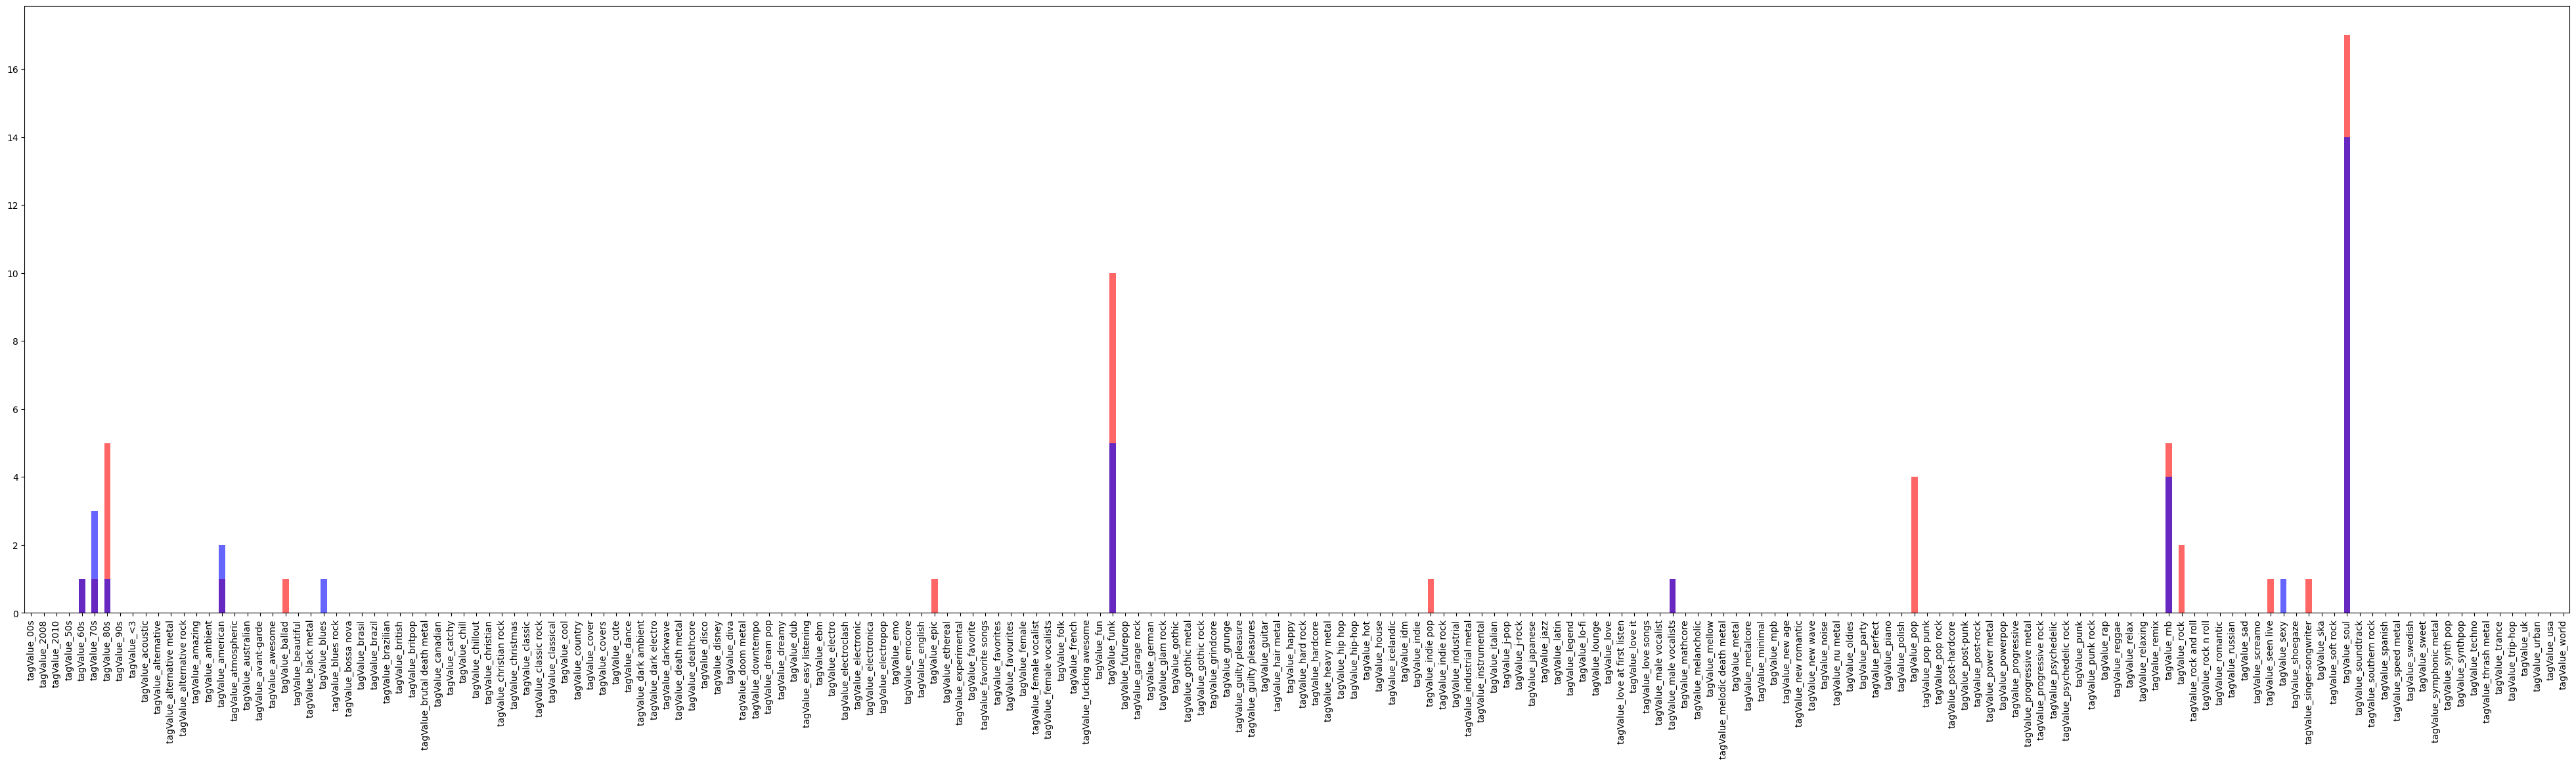

In [8]:

plt.figure(figsize=(50,12))

artist_vectors.loc["Stevie Wonder"].plot(kind="bar",color="red", alpha=0.6)
artist_vectors.loc["Marvin Gaye"].plot(kind="bar",color="blue", alpha=0.6)

In [9]:
user_artist_counts = uap.pivot_table(index="userID", columns="name", values="weight", aggfunc="sum").fillna(0)

(user_artist_counts.iloc[0,:]/user_artist_counts.iloc[0,:].sum()).shape

(17632,)

In [10]:

class Ridge(object):
    def __init__(self, alpha: float):
        self.alpha: float=alpha
        self.beta = None
    def fit(self, X: np.array, y: np.array):
        n=X.shape[0]
        self.beta = np.linalg.inv((X.T@X + self.alpha*np.identity(n)))@X.T@y
    


In [172]:
import random
user_id=200
user_artists = uap.query("userID==@user_id").name.values
artists = popular_artists.tail(350).index.values

X = pd.concat([artist_vectors.loc[i] for i in artists],axis=1).T
target = [(1 if i in user_artists else -1) for i in X.index]

l = 10
n,m = X.shape
xt_x_plus_li = (X.values.T@X.values )+ l*np.identity(m)

theta = np.linalg.inv(xt_x_plus_li)@X.T@target

alpha = 3
best_score = -1000
best_artist = None
scores = []
artists = []

A = np.identity(X.shape[1])
b = np.zeros(X.shape[1])


for t in range(5):
    artist_scores = np.zeros(X.shape[0])
    theta = np.linalg.inv(A) @ b

    p_ta = theta
    for i, artist in enumerate(X.index):
        x = X.loc[artist].values
        expected_reward = theta @ x

        ucb = expected_reward +  alpha * np.sqrt(
            x.T @ np.linalg.inv(A) @ x
        )
        artist_scores[i]=ucb
    
    nth_artist = np.argsort(artist_scores)[-1]
    
    x_cand = X.iloc[nth_artist]
    reward = target[nth_artist]
    print(X.index[nth_artist])
    
    A = A + A + x_cand @ x_cand.T
    
    b = b + reward * x_cand

    print(reward)
        
print(A)

Lady Gaga
-1
Led Zeppelin
1
Led Zeppelin
1
Led Zeppelin
1
Led Zeppelin
1
[[5991. 5959. 5959. ... 5959. 5959. 5959.]
 [5959. 5991. 5959. ... 5959. 5959. 5959.]
 [5959. 5959. 5991. ... 5959. 5959. 5959.]
 ...
 [5959. 5959. 5959. ... 5991. 5959. 5959.]
 [5959. 5959. 5959. ... 5959. 5991. 5959.]
 [5959. 5959. 5959. ... 5959. 5959. 5991.]]
